## Example: Autoregressive model

In this example we are going to perform an automated Variational Bayesian Inference for autoregressive model that can be represented as following:

$$
\begin{equation}
\begin{aligned}
p(\gamma) &= \mathrm{Gamma}(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}
\end{equation}
$$

where $x_t$ is a current state of our system, $\mathbf{x}_{t-1:t-k}$ is a sequence of $k$ previous states, $k$ is an order of autoregression process, $\mathbf{\theta}$ is a vector of transition coefficients, $\gamma$ is a precision of state transition process, $y_k$ is a noisy observation of $x_k$ with precision $\tau$.

For a more rigorous introduction to Bayesian inference in Autoregressive models we refer to [Albert Podusenko, Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

We start with importing all needed packages:

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, LinearAlgebra, Random, Plots, BenchmarkTools
using Parameters

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


Lets generate some synthetic dataset, we use a predefined sets of coeffcients for $k$ = 1, 3 and 5 respectively:

In [2]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [3]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)
    
    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(γ))
    
    states[1] = randn(rng, order)
    
    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 1 method)

In [4]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)

# Number of observations in synthetic dataset
n = 500

# AR process parameters
real_γ = 5.0
real_τ = 5.0
real_θ = coefs_ar_5

states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);

Lets plot our synthetic dataset:

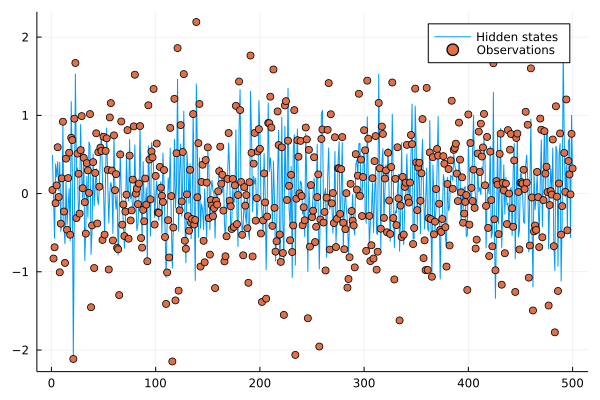

In [5]:
plot(first.(states), label = "Hidden states")
scatter!(observations, label = "Observations")

Next step is to specify probabilistic model and run inference procedure with `ReactiveMP`. We use `GraphPPL.jl` package to specify probabilistic model and additional constraints for variational Bayesian Inference. We also specify two different models for Multivariate AR with order $k$ > 1 and for Univariate AR (reduces to simple State-Space-Model) with order $k$ = 1.

In [79]:
@model [ default_factorisation = MeanField() ] function lar_model(T::Type{ Multivariate }, n, order, c, stype, τ)
    
    # Parameter priors 
    γ  ~ GammaShapeRate(1.0, 1.0) 
    θ  ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)
    
    # Prior for first state
    x0 ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Multivariate, order, stype)
    
    for i in 1:n
        # Autoregressive node uses structured factorisation assumption between states
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), cτ)
        x_prev = x[i]
    end
    return x, y, θ, γ
end

lar_model (generic function with 2 methods)

In [80]:
@model [ default_factorisation = MeanField() ] function lar_model(T::Type{Univariate}, n, order, c, stype, τ)
    
    # Parameter priors 
    γ  ~ GammaShapeRate(1.0, 1.0)
    θ  ~ NormalMeanPrecision(0.0, 1.0)
    
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ) 

    # Prior for first state
    x0 ~ NormalMeanPrecision(0.0, 1.0)
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Univariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(ct * x[i], cτ)
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model (generic function with 2 methods)

In [98]:
order = 5
artype = Multivariate
c = ReactiveMP.ar_unit(artype, order)
result = inference(model=() -> lar_model(artype, length(observations), order, c, ARsafe(), real_τ, options = (limit_stack_depth = 100,)), 
                   data=Dict(:y => observations), 
                   initmarginals=Dict(:γ => GammaShapeRate(1.0, 1.0), :θ => MvNormalMeanPrecision(zeros(order), diageye(order))),
                   free_energy=true,
                   iterations=100, showprogress=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [99]:
@unpack x0, x, γ, θ = result.posteriors

fe = result.free_energy;

We will use different initial marginals depending on type of our AR process

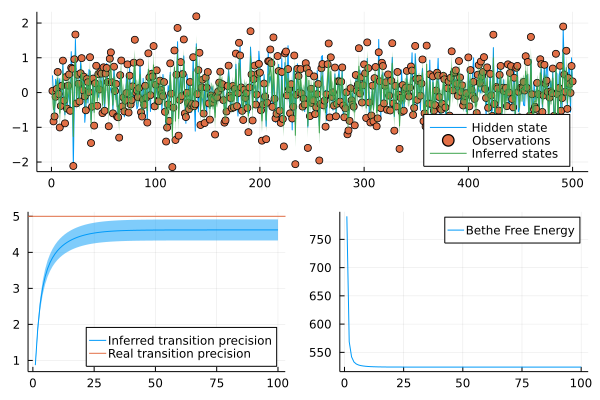

In [100]:
p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(xs)), ribbon = sqrt.(first.(var.(xs))), label="Inferred states", legend = :bottomright)

p2 = plot(mean.(γ), ribbon = std.(γ), label = "Inferred transition precision", legend = :bottomright)
p2 = plot!([ real_γ ], seriestype = :hline, label = "Real transition precision")

p3 = plot(fe, label = "Bethe Free Energy")

plot(p1, p2, p3, layout = @layout([ a; b c ]))

Lets also plot a subrange of our results:

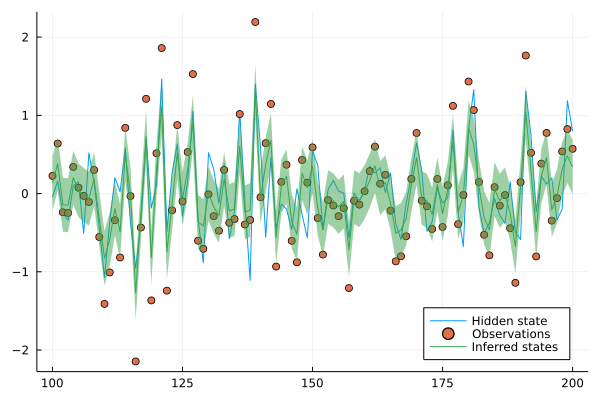

In [101]:
subrange = div(n,5):(div(n, 5) + div(n, 5))

plot(subrange, first.(states)[subrange], label="Hidden state")
scatter!(subrange, observations[subrange], label="Observations")
plot!(subrange, first.(mean.(xs))[subrange], ribbon = sqrt.(first.(var.(xs)))[subrange], label="Inferred states", legend = :bottomright)

It is also interesting to see where our AR coefficients converge to:

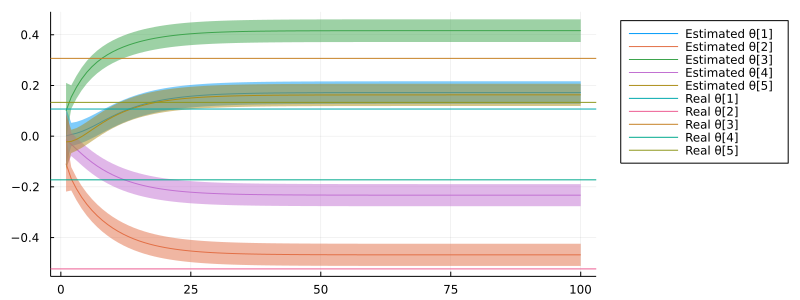

In [102]:
let
    pθ = plot()

    θms = mean.(θ)
    θvs = var.(θ)
    
    l = length(θms)

    edim(e) = (a) -> map(r -> r[e], a)

    for i in 1:length(first(θms))
        pθ = plot!(pθ, θms |> edim(i), ribbon = θvs |> edim(i) .|> sqrt, label = "Estimated θ[$i]")
    end
    
    for i in 1:length(real_θ)
        pθ = plot!(pθ, [ real_θ[i] ], seriestype = :hline, label = "Real θ[$i]")
    end
    
    plot(pθ, legend = :outertopright, size = (800, 300))
end

In [103]:
println("$(length(real_θ))-order AR inference Bethe Free Energy: ", last(fe))

5-order AR inference Bethe Free Energy: 523.9406680843922


We can also run a 1-order AR inference on 5-order AR data:

In [104]:
order = 1
artype = Univariate
c = ReactiveMP.ar_unit(artype, order)
result = inference(model=() -> lar_model(artype, length(observations), order, c, ARsafe(), real_τ, options = (limit_stack_depth = 100,)), 
                   data=Dict(:y => observations), 
                   initmarginals=Dict(:γ => GammaShapeRate(1.0, 1.0), :θ => NormalMeanPrecision(0.0, 1.0)),
                   free_energy=true,
                   iterations=100, showprogress=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [105]:
@unpack x0, x, γ, θ = result.posteriors

fe = result.free_energy;

In [106]:
println("1-order AR inference Bethe Free Energy: ", last(fe))

1-order AR inference Bethe Free Energy: 535.3776476866639


We can see that, according to final Bethe Free Energy value, in this example 5-order AR process can describe data better than 1-order AR.

We may be also interested in benchmarking our algorithm:

In [115]:
println("Benchmark for n = $n and AR-$(length(real_θ)) inference");
order = 1
artype = Univariate
c = ReactiveMP.ar_unit(artype, order)
@benchmark inference(model=() -> lar_model(artype, length($observations), order, c, ARsafe(), real_τ), 
                     data=Dict(:y => $observations), 
                     initmarginals=Dict(:γ => GammaShapeRate(1.0, 1.0), :θ => NormalMeanPrecision(0.0, 1.0)),
                     free_energy=true,
                     iterations=15)

Benchmark for n = 500 and AR-5 inference


BenchmarkTools.Trial: 22 samples with 1 evaluation.
 Range (min … max):  199.458 ms … 339.034 ms  ┊ GC (min … max): 17.39% … 16.96%
 Time  (median):     218.868 ms               ┊ GC (median):    17.14%
 Time  (mean ± σ):   234.911 ms ±  38.378 ms  ┊ GC (mean ± σ):  17.65% ±  2.95%

     ▃█ ▃ ▃ ▃▃                                                   
  ▇▁▁██▇█▇█▁██▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▇▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  199 ms           Histogram: frequency by time          339 ms <

 Memory estimate: 102.35 MiB, allocs estimate: 1859038.

In [117]:
println("Benchmark for n = $n and AR-$(length(real_θ)) inference");
order = 5
artype = Multivariate
c = ReactiveMP.ar_unit(artype, order)
@benchmark inference(model=() -> lar_model(artype, length($observations), order, c, ARsafe(), real_τ, options = (limit_stack_depth = 100,)), 
                     data=Dict(:y => $observations), 
                     initmarginals=Dict(:γ => GammaShapeRate(1.0, 1.0), :θ => MvNormalMeanPrecision(zeros(order), diageye(order))),
                     free_energy=true,
                     iterations=15)

Benchmark for n = 500 and AR-5 inference


BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  485.437 ms … 668.423 ms  ┊ GC (min … max): 17.40% … 15.55%
 Time  (median):     528.746 ms               ┊ GC (median):    19.65%
 Time  (mean ± σ):   551.685 ms ±  64.714 ms  ┊ GC (mean ± σ):  19.49% ±  2.53%

  █   ▁  ▁    ▁   ▁                ▁▁               ▁         ▁  
  █▁▁▁█▁▁█▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█ ▁
  485 ms           Histogram: frequency by time          668 ms <

 Memory estimate: 336.16 MiB, allocs estimate: 2670848.